In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import random


In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [4]:
class AGCODataset(Dataset):
    def __init__(self, good_image_dir, synthetic_image_dir, transform=None):
        self.good_image_dir = good_image_dir
        self.synthetic_image_dir = synthetic_image_dir
        self.transform = transform
        self.data = []

        # Load good images (label 0, no mask)
        for img_file in os.listdir(good_image_dir):
            img_path = os.path.join(good_image_dir, img_file)
            if os.path.isfile(img_path):
                self.data.append((img_path, None, 0))  # No mask for good images

        # Load synthetic anomaly images and their masks (label 1)
        for img_file in os.listdir(synthetic_image_dir):
            if '_anomaly' in img_file:
                img_path = os.path.join(synthetic_image_dir, img_file)
                mask_file = img_file.replace('_anomaly', '_mask')
                mask_path = os.path.join(synthetic_image_dir, mask_file)
                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    self.data.append((img_path, mask_path, 1))  # Label 1 for anomalies

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, mask_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L') if mask_path else None

        if self.transform:
            image = self.transform(image)
            if mask:
                mask = self.transform(mask)  # Apply the same transformation to the mask
            else:
                mask = torch.zeros((1, 256, 256))  # Dummy mask for "good" images

        return image, mask, label

In [5]:
# Instantiate the dataset
normal_dir = "../../datasets/agco_front/normal"
anomaly_dir = "../../datasets/agco_front/synthetic_normal_clone_with_mask/"

In [6]:
dataset = AGCODataset(normal_dir, anomaly_dir, transform=transform)

In [7]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

In [8]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
for images, masks, _ in dataloader:
    print(images.shape, masks.shape) 
    break

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 256, 256])


In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 2439
Validation set size: 814


In [12]:
class TransposeBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransposeBasicBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=2, output_padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        # Perform upsampling path
        upsampled = self.upsample(x)

        return self.relu(out + upsampled)

class ResNetEncDec(nn.Module):
    def __init__(self):
        super(ResNetEncDec, self).__init__()

        # Encoder: Using ResNet layers up to layer4
        resnet = models.resnet18(pretrained=True)
        
        # Encoder layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4


        # Note: decrease the complexity on the model
        # Note: train more epochs
        
        # NIN layer (512 -> 256 -> 128)
        self.nin = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True)
        )

        # Decoder (TransposeBasicBlock layers)
        self.uplayer1 = TransposeBasicBlock(128, 64)
        self.uplayer2 = TransposeBasicBlock(64, 32)
        self.uplayer3 = TransposeBasicBlock(32, 16)

        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2.0, mode='bilinear')

        # Final conv layer
        self.convtranspose1 = nn.ConvTranspose2d(16, 1, kernel_size=7, stride=2, padding=3, output_padding=1, bias=False)

        # Final activation (Identity in this case)
        self.final_activation = nn.Identity()

        # Classification layer for image-level classification
        self.classifier = nn.Linear(128, 1)  # Binary classification (good vs anomaly)

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # NIN Layer
        x = self.nin(x)

        # Decoder layers
        decoded = self.uplayer1(x)
        decoded = self.uplayer2(decoded)
        decoded = self.uplayer3(decoded)

        # Upsample
        decoded = self.upsample(decoded)

        # Final convolution
        decoded = self.convtranspose1(decoded)

        # Final activation (here it's Identity)
        decoded = self.final_activation(decoded)

        # Image-level classification
        x = torch.mean(x, dim=[2, 3])  # Global Average Pooling
        class_output = self.classifier(x)
        class_output = torch.sigmoid(class_output)

        return decoded, class_output

In [13]:
model = ResNetEncDec().to(device)
# model

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for pixel-wise classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [15]:
# # Check what each batch from the dataloader looks like
# for batch in train_loader:
#     print(f"Batch output: {batch}")
#     break  # Just check the first batch

In [16]:
num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for images, masks, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        decoded, _ = model(images)  # Get only the pixel-level output for segmentation
        decoded = torch.sigmoid(decoded)  # Ensure output is in [0, 1] range

        # Compute loss
        loss = criterion(decoded, masks)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
            val_images, val_masks = val_images.to(device), val_masks.to(device)

            # Forward pass
            val_decoded, _ = model(val_images)
            val_decoded = torch.sigmoid(val_decoded)  # Sigmoid activation for BCE

            # Compute validation loss
            val_loss = criterion(val_decoded, val_masks)
            running_val_loss += val_loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    
    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"./best_model_pixel_level_1.pth")
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

Epoch 1/10 - Training:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 0.4658, Val Loss: 0.2929
Best model saved with validation loss: 0.2929


Epoch [2/10] - Train Loss: 0.2062, Val Loss: 0.1459
Best model saved with validation loss: 0.1459


Epoch [3/10] - Train Loss: 0.1157, Val Loss: 0.0900
Best model saved with validation loss: 0.0900


Epoch [4/10] - Train Loss: 0.0761, Val Loss: 0.0605
Best model saved with validation loss: 0.0605


Epoch [5/10] - Train Loss: 0.0533, Val Loss: 0.0436
Best model saved with validation loss: 0.0436


Epoch [6/10] - Train Loss: 0.0386, Val Loss: 0.0334
Best model saved with validation loss: 0.0334


Epoch [7/10] - Train Loss: 0.0296, Val Loss: 0.0263
Best model saved with validation loss: 0.0263


Epoch [8/10] - Train Loss: 0.0239, Val Loss: 0.0213
Best model saved with validation loss: 0.0213


Epoch [9/10] - Train Loss: 0.0199, Val Loss: 0.0188
Best model saved with validation loss: 0.0188


Epoch [10/10] - Train Loss: 0.0170, Val Loss: 0.0165
Best model saved with validation loss: 0.0165


In [23]:
def visualize_predictions(model, dataset, device, num_images=5):
    model.eval()
    fig, axs = plt.subplots(num_images, 3, figsize=(12, num_images * 4))
    
    # Select random indices from the validation dataset
    random_indices = random.sample(range(len(dataset)), num_images)
    
    with torch.no_grad():
        for i, idx in enumerate(random_indices):
            # Get the image and mask from the dataset
            image, true_mask, _ = dataset[idx]
            
            # Move the image to the device and add a batch dimension
            image = image.to(device).unsqueeze(0)
            
            # Get model prediction
            pred_mask, _ = model(image)
            pred_mask = torch.sigmoid(pred_mask)  # Apply sigmoid to get probabilities
            
            # Move tensors to CPU and remove batch dimension for visualization
            image = image.squeeze().cpu().permute(1, 2, 0)
            true_mask = true_mask.squeeze().cpu()
            pred_mask = pred_mask.squeeze().cpu()
            
            # Plot original image, true mask, and predicted mask
            axs[i, 0].imshow(image)
            axs[i, 0].set_title("Input Image")
            axs[i, 0].axis("off")

            axs[i, 1].imshow(true_mask, cmap="gray")
            axs[i, 1].set_title("True Mask")
            axs[i, 1].axis("off")

            axs[i, 2].imshow(pred_mask, cmap="gray")
            axs[i, 2].set_title("Predicted Mask")
            axs[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

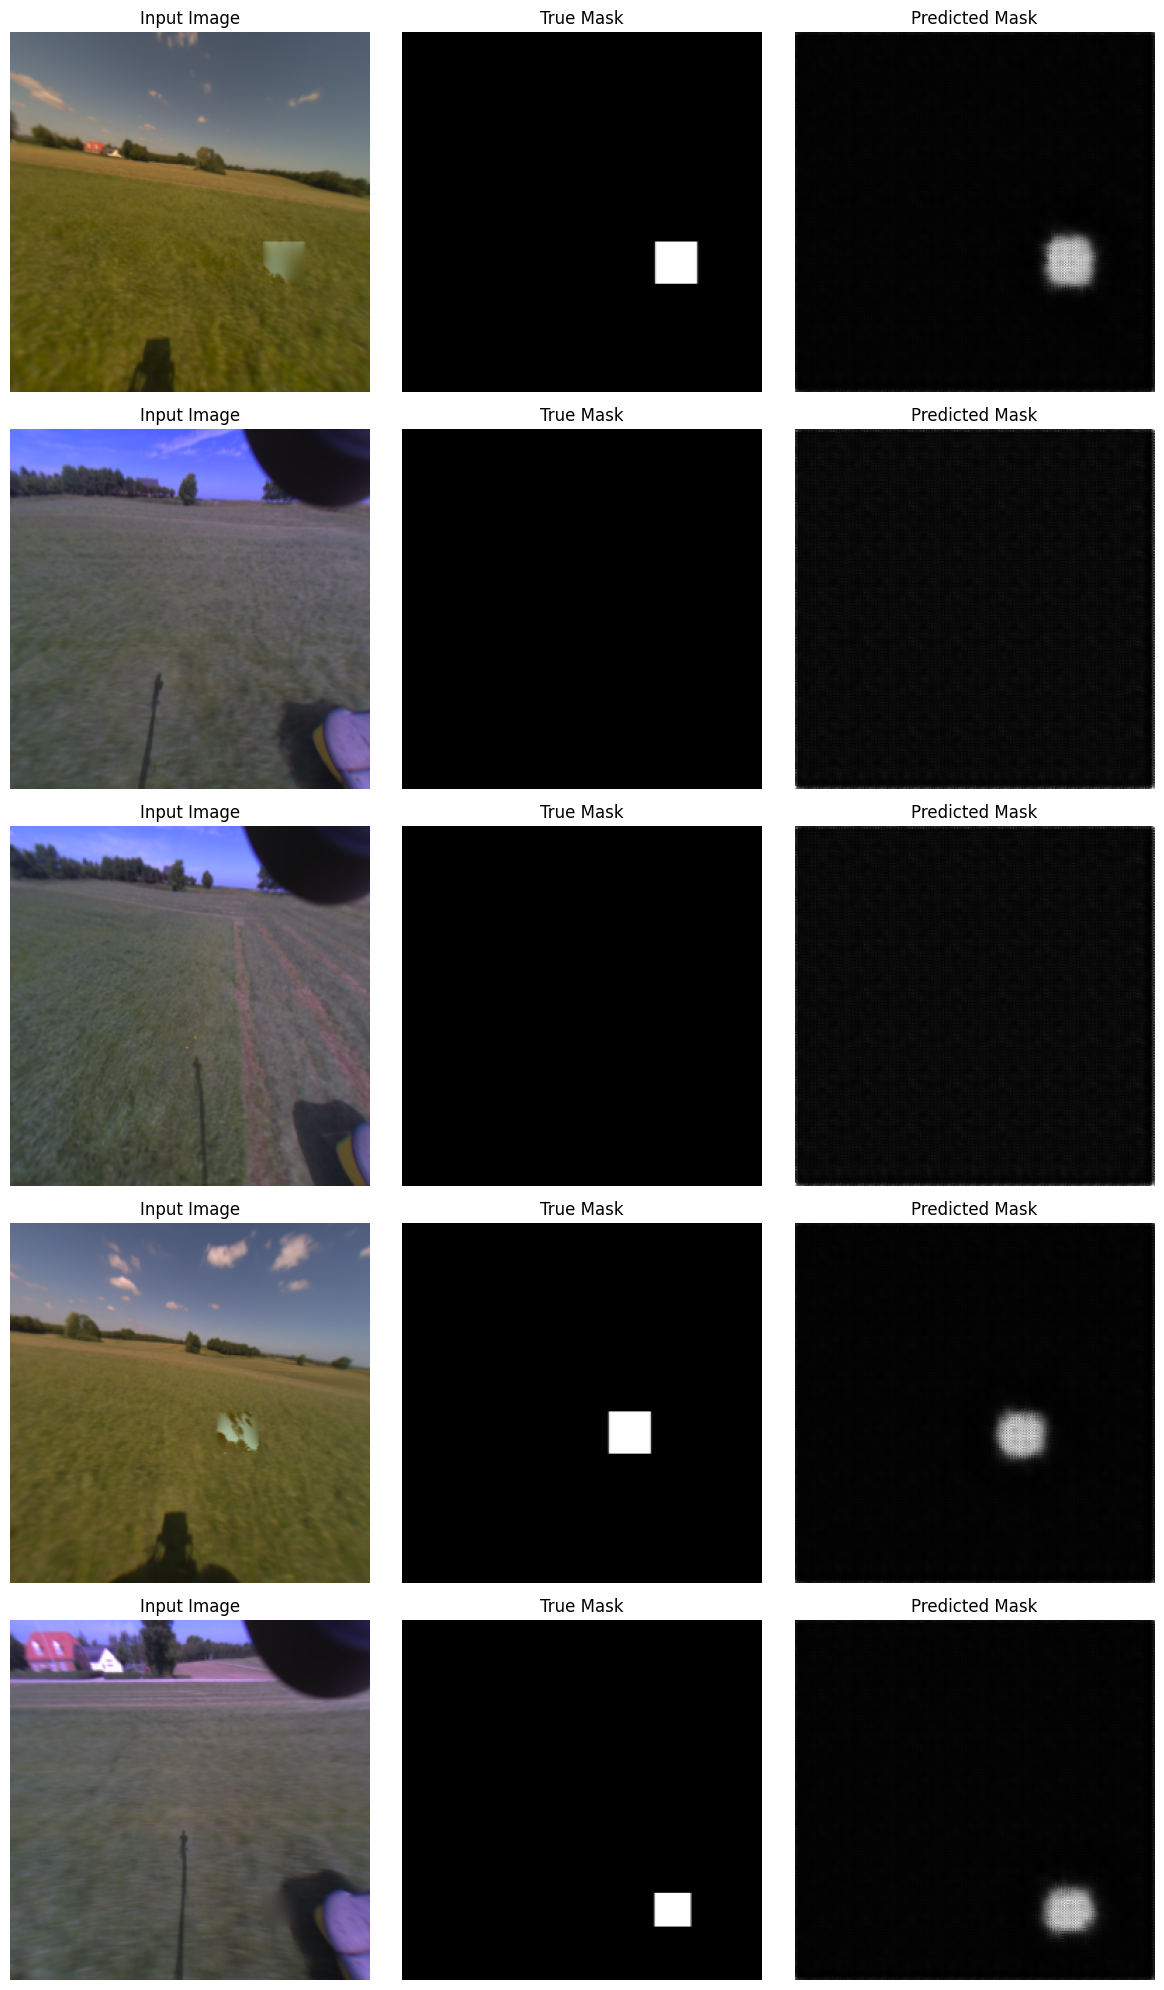

In [24]:
model.load_state_dict(torch.load("./best_model_pixel_level_1.pth"))
model.to(device)

visualize_predictions(model, val_dataset, device)